### Summary

- Experiment with a model that can detect poses by vertices and edges of a humanoid form

### Import and Asset Dump

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile
from urllib.request import urlretrieve

from IPython.display import YouTubeVideo, display, Image

%matplotlib inline

def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assests....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)

URL = r"https://www.dropbox.com/s/089r2yg6aao858l/opencv_bootcamp_assets_NB14.zip?dl=1"

asset_zip_path = os.path.join(os.getcwd(), f"opencv_bootcamp_assets_NB14.zip")

# Download if assest ZIP does not exists. 
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)   

### Pose Detection

The model binds keypoints in the human anatomy.

This is hard becaus it can easily create occlusions

First we estabish the important files for the model:

In [3]:
proto_file = "pose_deploy_linevec_faster_4_stages.prototxt"
weights_file = "model/pose_iter_160000.caffemodel"

Then we define the model and its points

In [4]:
num_of_points = 15
pose_pairs = [
    [0, 1],
    [1, 2],
    [2, 3],
    [3, 4],
    [1, 5],
    [5, 6],
    [6, 7],
    [1, 14],
    [14, 8],
    [8, 9],
    [9, 10],
    [14, 11],
    [11, 12],
    [12, 13],
] # these are links of the human anatomy's keypoints

model = cv2.dnn.readNetFromCaffe(proto_file, weights_file)

Read the image to be used for the model

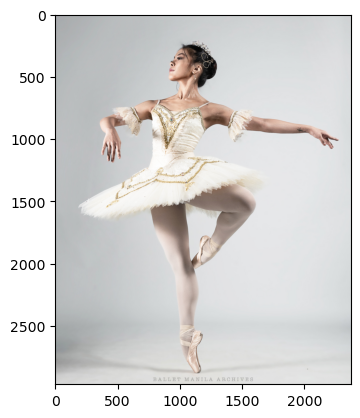

In [5]:
img = cv2.imread("ball.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_width = img.shape[1]
img_height = img.shape[0]

# show img
plt.imshow(img)

This is a nice image to challenge the model because there are weird keypoints in the below half and occlusions with the arms and legs

Then we create the blob for the image

In [6]:
input_size = (368, 368)
blob = cv2.dnn.blobFromImage(img, 1/255, input_size, (0, 0, 0), swapRB=True, crop=False)
model.setInput(blob)

Do inference with the blob through forward passes

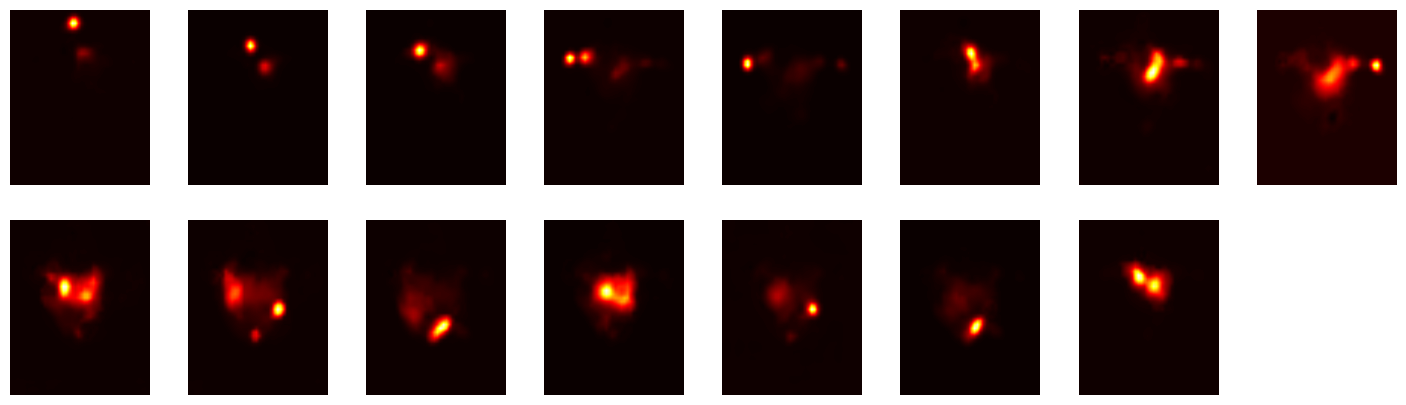

In [7]:
output = model.forward()

# display possibility/probability maps (heatmaps) of the keypoints in the human anatomy might be in the img
plt.figure(figsize=(18, 5))
for i in range(num_of_points):
    poss_map = output[0, i, :, :]
    display_map = cv2.resize(poss_map, (img_width, img_height), cv2.INTER_LINEAR)
    plt.subplot(2, 8, i+1)
    plt.axis("off")
    plt.imshow(display_map, cmap="hot")

Extract keypoints to be displayed

In [8]:
# scale x and y for keypoints
scale_x = img_width / output.shape[3]
scale_y = img_height / output.shape[2]

keypoints = []

threshold = 0.05

for i in range(num_of_points):
    poss_map = output[0, i, :, :]

    # find global maxima in heatmap
    min_val, prob, min_loc, point = cv2.minMaxLoc(poss_map)

    # scale points to fit original image
    x = scale_x * point[0]
    y = scale_y * point[1]

    if prob > threshold:
        keypoints.append((int(x), int(y)))

Display keypoints with original image and a skeleton (keypoints connected)

In [9]:
img_points = img.copy()
img_skeleton = img.copy()

# draw points
for i, p in enumerate(keypoints):
    cv2.circle(img_points, p, 10, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)
    cv2.putText(img_points, str(i), p, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, lineType=cv2.LINE_AA)

# draw skeleton
for p in pose_pairs:
    p1 = p[0]
    p2 = p[1]
    if keypoints[p1] and keypoints[p2]:
        cv2.line(img_skeleton, keypoints[p1], keypoints[p2], (255, 255, 0), 3)
        cv2.circle(img_skeleton, keypoints[p1], 10, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

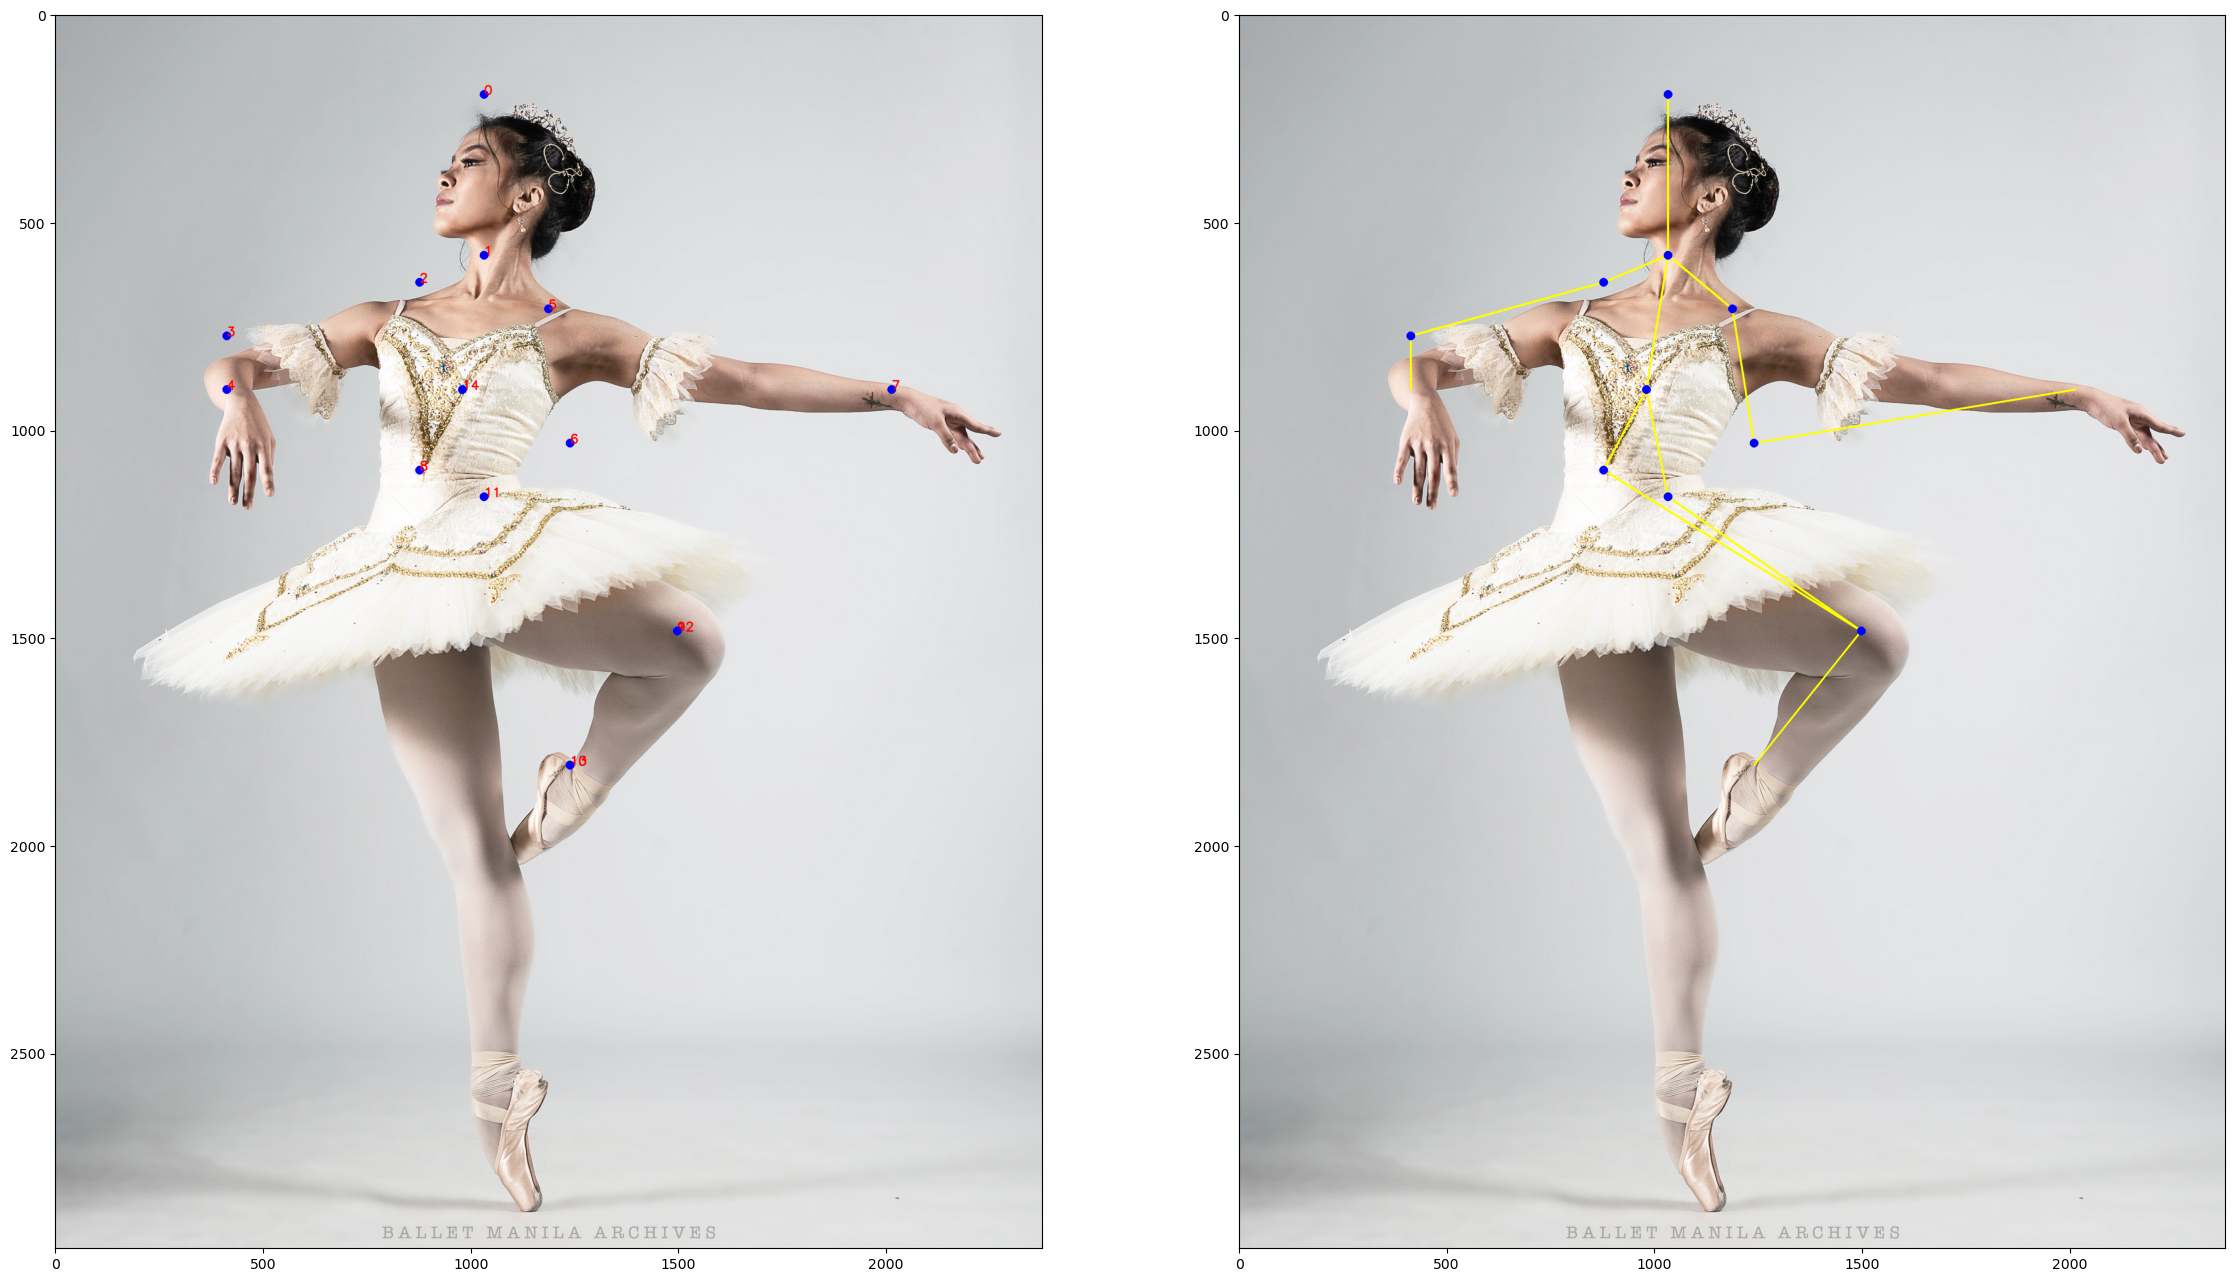

In [10]:
plt.figure(figsize=(28, 20))

plt.subplot(121)
plt.imshow(img_points)

plt.subplot(122)
plt.imshow(img_skeleton)